# 【案例9】城际列车的运行时刻安排——参考求解

In [20]:
# 输入参数
import pandas as pd
import numpy as np
train_data = pd.read_excel("case_1_data.xlsx")

# 将时间转化为分钟为单位
train_data['发车时间'] = pd.to_datetime(train_data['发车时间'].astype(str), format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(train_data['发车时间'].astype(str), format='%H:%M:%S').dt.minute
train_data['到达时间'] = pd.to_datetime(train_data['到达时间'].astype(str), format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(train_data['到达时间'].astype(str), format='%H:%M:%S').dt.minute
uptrain = train_data[train_data['上下行']=='上行'].head(12)
downtrain = train_data[train_data['上下行']=='下行'].head(12)
print("UpTrains:")
display(uptrain)
print("DownTrains:")
display(downtrain)


# 上下行线路数量
M = len(uptrain['发车时间'])
N = len(downtrain['发车时间'])
print(f"上行线路{M}条，下行线路{N}条")

# 机车的牵引重量
weight = [1,2,1,2,2,2,2,2,2]
MOTIVE_NUM = len(weight)

# 上下行线路所需的重量
weight_trainup = list(uptrain['列车重量'])
weight_traindown = list(downtrain['列车重量'])

#上行线路i实际的出发时间t_i_smin t_i_smax ，到达时间t_i_emin t_i_emax在公布时刻表的T_DELTA = 2分钟之内调整
T_DELTA = 2
ti_smin = [t-T_DELTA for t in  list(uptrain['发车时间'])]
ti_smax = [t+T_DELTA for t in  list(uptrain['发车时间'])]
ti_emin = [t-T_DELTA for t in  list(uptrain['到达时间'])]
ti_emax = [t+T_DELTA for t in  list(uptrain['到达时间'])]
# 下行列车同理：
tj_smin = [t-T_DELTA for t in  list(downtrain['发车时间'])]
tj_smax = [t+T_DELTA for t in  list(downtrain['发车时间'])]
tj_emin = [t-T_DELTA for t in  list(downtrain['到达时间'])]
tj_emax = [t+T_DELTA for t in  list(downtrain['到达时间'])]


# 技术等待时间
theta_i = 20
theta_j = 30

# 最小列车间隔12分钟
H_UP_MIN = 12
H_DOWN_MIN = 12


UpTrains:


,车次,发车站,发车时间,到达站,到达时间,上下行,列车重量
12,C2,B,379,A,409,上行,1
13,C4,B,393,A,426,上行,2
14,C6,B,446,A,476,上行,2
15,C8,B,557,A,594,上行,2
16,C10,B,609,A,639,上行,2
17,C12,B,677,A,707,上行,1
18,C14,B,721,A,751,上行,2
19,C16,B,781,A,811,上行,2
20,C18,B,837,A,867,上行,2
21,C20,B,941,A,971,上行,2


DownTrains:


,车次,发车站,发车时间,到达站,到达时间,上下行,列车重量
0,C1,A,375,B,415,下行,1
1,C3,A,513,B,543,下行,2
2,C5,A,571,B,601,下行,1
3,C7,A,613,B,650,下行,2
4,C9,A,668,B,698,下行,1
5,C11,A,732,B,762,下行,1
6,C13,A,771,B,801,下行,2
7,C15,A,891,B,921,下行,1
8,C17,A,908,B,938,下行,1
9,C19,A,1042,B,1072,下行,2


上行线路12条，下行线路12条


In [2]:
# 将浮点数转换为时间
def min2time(minutes):
    minutes = int(minutes) 
    hours = minutes // 60
    minutes = minutes % 60
    return f"{hours}:{minutes:02d}"
# 以360分钟为例
minutes = 360.0
time = min2time(minutes)
print(time)

6:00


## 1. 求解最小车辆数量（求解时间约50秒）

In [25]:
# 求解问题-最小车辆数量
from pulp import *
prob = LpProblem("train", LpMinimize)

# 创建变量
# x_up[ijk] 机车k执行上行线路i后执行下行线路j（包括出库（i=0->j）选择回库（i=?->j=N+1））
x_up = LpVariable.dicts('x_up', [(i,j,k) for i in range(0, M+1) for j in range(1, N+2) for k in range(1,MOTIVE_NUM+1) ], cat='Binary')
# x_down[jik] 机车k执行下行线路j后执行上行线路i（包括出库（j=0->i=?）选择回库（j=?->i=M+1））
x_down = LpVariable.dicts('x_down', [(j,i,k) for j in range(0, N+1) for i in range(1, M+2) for k in range(1,MOTIVE_NUM+1) ], cat='Binary')

#xe[k] 机车k是否执行任务
xe = LpVariable.dicts('xe',[k for k in range(1,MOTIVE_NUM+1)],cat='Binary')

# 上行线路i的实际发车时间ti_s，到达时间ti_e
ti_s = LpVariable.dicts("ti_s", range(1, M+1), cat='Continuous')
ti_e = LpVariable.dicts("ti_e", range(1, M+1), cat='Continuous')
# 下行线路j的实际发车时间tj_s，到达时间tj_e
tj_s = LpVariable.dicts("tj_s", range(1, N+1), cat='Continuous')
tj_e = LpVariable.dicts("tj_e", range(1, N+1), cat='Continuous')
#x_up[i,j,k] :x_up[i,j,k]的的辅助变量AAA
y_up = LpVariable.dicts("y_up",[(i,j,k) for i in range(1,M+1) for j in range(1,N+1) for k in range(1,MOTIVE_NUM+1)],cat='Continuous')
# y_down[j,i,k]:x_down[j,i,k]的辅助变量AAA
y_down = LpVariable.dicts("y_down",[(j,i,k) for j in range(1,N+1) for i in range(1,M+1) for k in range(1,MOTIVE_NUM+1)],cat='Continuous')

TotalMotive = LpVariable("TotalMotive", lowBound=0, cat='Continuous') 
TotalWait = LpVariable("TotalWait",lowBound = 0,cat='Continuous')


# 定义问题
prob += TotalMotive

# 定义约束
prob += TotalMotive == lpSum(xe[k] for k in range(1,MOTIVE_NUM+1) )
prob += TotalMotive >= 0
prob += TotalWait == lpSum(y_up[i,j,k] for k in range(1,MOTIVE_NUM+1) for i in range(1,M+1) for j in range(1,N+1)) + lpSum( y_down[j,i,k] for j in range(1,N+1) for i in range(1,M+1) for k in range(1,MOTIVE_NUM+1))
BIGM = 999999999
for i in range(1,M+1):
    for j in range(1,N+1):
        for k in range(1,MOTIVE_NUM+1):
            prob += y_up[i,j,k] <= BIGM*x_up[i,j,k]
            prob += y_up[i,j,k]-(tj_s[j]-ti_e[i]) <= BIGM * (1-x_up[i,j,k])
            prob += y_up[i,j,k]-(tj_s[j]-ti_e[i]) >= BIGM * (x_up[i,j,k]-1)
            prob += y_up[i,j,k] >= 0
            
            prob += y_down[j,i,k] <= BIGM*x_down[j,i,k]
            prob += y_down[j,i,k]-(ti_s[i]-tj_e[j]) <= BIGM * (1-x_down[j,i,k])
            prob += y_down[j,i,k]-(ti_s[i]-tj_e[j]) >= BIGM * (x_down[j,i,k]-1)
            prob += y_down[j,i,k] >= 0
                           
#执行上行线路i前必须且仅有一个下行线路j（包括从上行线出库的情况）
for i in range(1,M+1):
    prob += lpSum(x_down[j,i,k] for k in range(1,MOTIVE_NUM+1) for j in range(0,N+1)) == 1
# 执行下行线路j前必须且仅有一个上行线路i（包括从下行线出库的情况）
for j in range(1,N+1):
    prob += lpSum(x_up[i,j,k] for k in range(1,MOTIVE_NUM+1) for i in range(0,M+1)) == 1
    
# 列车的运行线路是连续的
for k in range(1,MOTIVE_NUM+1):
    for j in range(1,N+1):
        prob += lpSum(x_up[i,j,k] for i in range(0,M+1)) <= lpSum(x_down[j,i,k] for i in range(1,M+2))
    for i in range(1,M+1):
        prob += lpSum(x_down[j,i,k] for j in range(0,N+1)) <= lpSum(x_up[i,j,k] for j in range(1,N+2))

# 出库的车辆等于入库的车辆
for k in range(1,MOTIVE_NUM+1):
    prob += lpSum(x_up[0,j,k] for j in range(1,N+2))+lpSum(x_down[0,i,k] for i in range(1,M+2)) == xe[k]
    prob += lpSum(x_up[i,N+1,k] for i in range(0,M+1))+lpSum(x_down[j,M+1,k] for j in range(0,N+1)) == xe[k]

# 如果列车k不上线运行，则任意x_up[i,j,k],x_down[j,i,k]=0
for k in range(1,MOTIVE_NUM + 1):
    for i in range(0,M+1):
        for j in range(1,N+2):
            prob += x_up[i,j,k] <= xe[k]
    for j in range(0,N+1):
        for i in range(1,M+2):
            prob += x_down[j,i,k] <= xe[k]

#时光不能倒流，执行下一次列车的最晚出发时间不能晚于上一次列车的最早到达时间+准备时间
for i in range(1,M+1):
    for j in range(1,N+1):
        if ti_emin[i-1] + theta_j  > tj_smax[j-1] :
            # print(f"上行{i}最早到达时间{ti_emin[i-1]},下行{j}最晚出发时间{tj_smax[j-1]} ")
            for k in range(1,MOTIVE_NUM+1):
                prob += x_up[i,j,k] == 0
        if tj_emin[j-1] + theta_i  > ti_smax[i-1]:
            # print(f"下行{j}最早到达时间{tj_emin[j-1]},上行{i}最晚出发时间{ti_smax[i-1]}")
            for k in range(1,MOTIVE_NUM+1):
                prob += x_down[j,i,k] == 0
            
#每辆车执行的任务数量<=8
for k in range (1,MOTIVE_NUM+1):
    prob += lpSum(x_up[i,j,k] for i in range(0,M+1) for j in range(1,N+2)) + lpSum(x_down[j,i,k] for i in range(1,M+2) for j in range(0,N+1)) <= 8
    
# 列车发车与到达的时间限制
for i in range(1,M+1):
    prob += ti_s[i] <= ti_smax[i-1]
    prob += ti_smin[i-1] <= ti_s[i]
    prob += ti_e[i] <= ti_emax[i-1]
    prob += ti_emin[i-1] <= ti_e[i]
for j in range(1,N+1):
    prob += tj_s[j] <= tj_smax[j-1]
    prob += tj_smin[j-1] <= tj_s[j]
    prob += tj_e[j] <= tj_emax[j-1]
    prob += tj_emin[j-1] <= tj_e[j]
    
# 最小时间间隔限制
for i in range(1,M):
    prob += ti_s[i+1] - ti_s[i] >= H_UP_MIN
    prob += ti_e[i+1] - ti_e[i] >= H_UP_MIN
for j in range(1,N):
    prob += tj_s[j+1] - tj_s[j] >= H_DOWN_MIN
    prob += tj_e[j+1] - tj_e[j] >= H_DOWN_MIN    

# 牵引重量限制
for i in range(1,M+1):
    prob += lpSum(weight[k-1]*x_up[i,j,k] for k in range(1,MOTIVE_NUM+1) for j in range(1,N+2)) >= weight_trainup[i-1]
    
# 牵引重量限制
for j in range(1,N+1):
    prob += lpSum(weight[k-1]*x_down[j,i,k] for k in range(1,MOTIVE_NUM+1) for i in range(1,M+2)) >= weight_traindown[j-1]

# 求解问题
prob.solve()

if LpStatus[prob.status] == "Optimal":  
    print("找到最优解")
else:
    print("No solution")

找到最优解


Best Motive number:4.0
Shorest wait time:1747.0
Train 1:


<Figure size 800x200 with 0 Axes>

Train 2:
执行线路C11（down j=6）,离开A时间:12:10 到达B时间12:40 
执行线路C19（down j=10）,离开A时间:17:20 到达B时间17:50 
执行线路C23（down j=12）,离开A时间:20:55 到达B时间21:28 
执行线路C8（up i=4）, 离开B时间:9:15 到达A时间9:52 
执行线路C20（up i=10）, 离开B时间:15:39 到达A时间16:13 
执行线路C24（up i=12）, 离开B时间:18:11 到达A时间18:48 


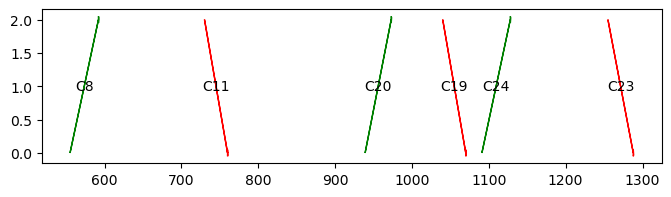

Train 3:


<Figure size 800x200 with 0 Axes>

Train 4:
执行线路C7（down j=4）,离开A时间:10:11 到达B时间10:52 
执行线路C13（down j=7）,离开A时间:12:49 到达B时间13:19 
执行线路C2（up i=1）, 离开B时间:6:17 到达A时间6:47 
执行线路C12（up i=6）, 离开B时间:11:15 到达A时间11:49 
执行线路C18（up i=9）, 离开B时间:13:55 到达A时间14:25 


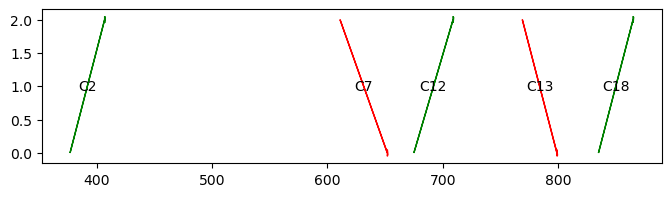

Train 5:
执行线路C1（down j=1）,离开A时间:6:13 到达B时间6:53 
执行线路C3（down j=2）,离开A时间:8:31 到达B时间9:01 
执行线路C9（down j=5）,离开A时间:11:06 到达B时间11:36 
执行线路C17（down j=9）,离开A时间:15:06 到达B时间15:36 
执行线路C6（up i=3）, 离开B时间:7:24 到达A时间7:58 
执行线路C10（up i=5）, 离开B时间:10:07 到达A时间10:41 
执行线路C16（up i=8）, 离开B时间:12:59 到达A时间13:29 


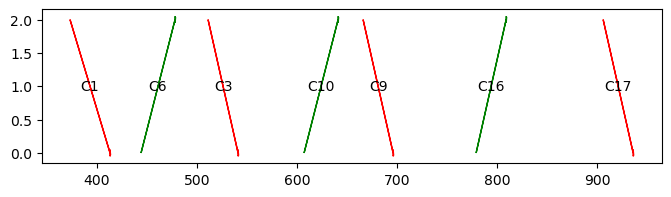

Train 6:


<Figure size 800x200 with 0 Axes>

Train 7:


<Figure size 800x200 with 0 Axes>

Train 8:


<Figure size 800x200 with 0 Axes>

Train 9:
执行线路C5（down j=3）,离开A时间:9:29 到达B时间10:03 
执行线路C15（down j=8）,离开A时间:14:49 到达B时间15:23 
执行线路C21（down j=11）,离开A时间:18:37 到达B时间19:10 
执行线路C4（up i=2）, 离开B时间:6:35 到达A时间7:04 
执行线路C14（up i=7）, 离开B时间:11:59 到达A时间12:33 
执行线路C22（up i=11）, 离开B时间:16:12 到达A时间16:46 


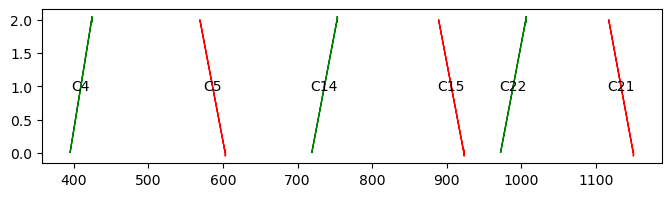

In [26]:
# 最小车辆数量
print(f"Best Motive number:{value(TotalMotive)}")
print(f"Shorest wait time:{value(TotalWait)}")
import matplotlib.pyplot as plt
if LpStatus[prob.status] == "Optimal":
    for k in range(1,MOTIVE_NUM+1):
        print(f"Train {k}:")
        plt.figure(figsize = (8,2))
        for i in range(0,M+1):
            for j in range(1, N+1):
                if value(x_up[i,j,k]) == 1:
                    # 绘制带箭头的线段
                    dx = value(tj_e[j]) - value(tj_s[j])
                    dy = -2
                    plt.arrow(value(tj_s[j]), 2, dx, dy, head_width=0.1, head_length=0.5, fc='red', ec='red')
                    # 添加文字标签
                    plt.text(value(tj_s[j])+dx/2, 1, f"{downtrain.iloc[j-1]['车次']}", ha='center', va='center')
                    print(f"执行线路{downtrain.iloc[j-1]['车次']}（down j={j}）,离开A时间:{min2time(value(tj_s[j]))} 到达B时间{min2time(value(tj_e[j]))} ")
        for j in range(0,N+1):
            for i in range(1, M+1):
                if value(x_down[j,i,k]) == 1:
                    # 绘制带箭头的线段
                    dx = value(ti_e[i]) - value(ti_s[i])
                    dy = 2
                    plt.arrow(value(ti_s[i]), 0, dx, dy, head_width=0.1, head_length=0.5, fc='green', ec='green')
                    plt.text(value(ti_s[i])+dx/2, 1, f"{uptrain.iloc[i-1]['车次']}", ha='center', va='center')
                    print(f"执行线路{uptrain.iloc[i-1]['车次']}（up i={i}）, 离开B时间:{min2time(value(ti_s[i]))} 到达A时间{min2time(value(ti_e[i]))} ")
        plt.show()
else:
    print("No solution")

## 2. 在知道最小车辆数=4的情况下，求解最短怠速时间（求解时间约25分钟）

In [23]:
# 求解问题-最小怠速时间
from pulp import *
prob = LpProblem("train", LpMinimize)

# 创建变量
# x_up[ijk] 机车k执行上行线路i后执行下行线路j（包括出库（i=0->j）选择回库（i=?->j=N+1））
x_up = LpVariable.dicts('x_up', [(i,j,k) for i in range(0, M+1) for j in range(1, N+2) for k in range(1,MOTIVE_NUM+1) ], cat='Binary')
# x_down[jik] 机车k执行下行线路j后执行上行线路i（包括出库（j=0->i=?）选择回库（j=?->i=M+1））
x_down = LpVariable.dicts('x_down', [(j,i,k) for j in range(0, N+1) for i in range(1, M+2) for k in range(1,MOTIVE_NUM+1) ], cat='Binary')

#xe[k] 机车k是否执行任务
xe = LpVariable.dicts('xe',[k for k in range(1,MOTIVE_NUM+1)],cat='Binary')

# 上行线路i的实际发车时间ti_s，到达时间ti_e
ti_s = LpVariable.dicts("ti_s", range(1, M+1), cat='Continuous')
ti_e = LpVariable.dicts("ti_e", range(1, M+1), cat='Continuous')
# 下行线路j的实际发车时间tj_s，到达时间tj_e
tj_s = LpVariable.dicts("tj_s", range(1, N+1), cat='Continuous')
tj_e = LpVariable.dicts("tj_e", range(1, N+1), cat='Continuous')
#x_up[i,j,k] :x_up[i,j,k]的的辅助变量AAA
y_up = LpVariable.dicts("y_up",[(i,j,k) for i in range(1,M+1) for j in range(1,N+1) for k in range(1,MOTIVE_NUM+1)],cat='Continuous')
# y_down[j,i,k]:x_down[j,i,k]的辅助变量AAA
y_down = LpVariable.dicts("y_down",[(j,i,k) for j in range(1,N+1) for i in range(1,M+1) for k in range(1,MOTIVE_NUM+1)],cat='Continuous')

TotalMotive = LpVariable("TotalMotive", lowBound=0, cat='Continuous') 
TotalWait = LpVariable("TotalWait",lowBound = 0,cat='Continuous')


# 定义问题
prob += TotalWait

# 定义约束
prob += TotalMotive == lpSum(xe[k] for k in range(1,MOTIVE_NUM+1) )
prob += TotalMotive <= 4
prob += TotalWait == lpSum(y_up[i,j,k] for k in range(1,MOTIVE_NUM+1) for i in range(1,M+1) for j in range(1,N+1)) + lpSum( y_down[j,i,k] for j in range(1,N+1) for i in range(1,M+1) for k in range(1,MOTIVE_NUM+1))
BIGM = 999999999
for i in range(1,M+1):
    for j in range(1,N+1):
        for k in range(1,MOTIVE_NUM+1):
            prob += y_up[i,j,k] <= BIGM*x_up[i,j,k]
            prob += y_up[i,j,k]-(tj_s[j]-ti_e[i]) <= BIGM * (1-x_up[i,j,k])
            prob += y_up[i,j,k]-(tj_s[j]-ti_e[i]) >= BIGM * (x_up[i,j,k]-1)
            prob += y_up[i,j,k] >= 0
            
            prob += y_down[j,i,k] <= BIGM*x_down[j,i,k]
            prob += y_down[j,i,k]-(ti_s[i]-tj_e[j]) <= BIGM * (1-x_down[j,i,k])
            prob += y_down[j,i,k]-(ti_s[i]-tj_e[j]) >= BIGM * (x_down[j,i,k]-1)
            prob += y_down[j,i,k] >= 0
                           
#执行上行线路i前必须且仅有一个下行线路j（包括从上行线出库的情况）
for i in range(1,M+1):
    prob += lpSum(x_down[j,i,k] for k in range(1,MOTIVE_NUM+1) for j in range(0,N+1)) == 1
# 执行下行线路j前必须且仅有一个上行线路i（包括从下行线出库的情况）
for j in range(1,N+1):
    prob += lpSum(x_up[i,j,k] for k in range(1,MOTIVE_NUM+1) for i in range(0,M+1)) == 1
    
# 列车的运行线路是连续的
for k in range(1,MOTIVE_NUM+1):
    for j in range(1,N+1):
        prob += lpSum(x_up[i,j,k] for i in range(0,M+1)) <= lpSum(x_down[j,i,k] for i in range(1,M+2))
    for i in range(1,M+1):
        prob += lpSum(x_down[j,i,k] for j in range(0,N+1)) <= lpSum(x_up[i,j,k] for j in range(1,N+2))

# 出库的车辆等于入库的车辆
for k in range(1,MOTIVE_NUM+1):
    prob += lpSum(x_up[0,j,k] for j in range(1,N+2))+lpSum(x_down[0,i,k] for i in range(1,M+2)) == xe[k]
    prob += lpSum(x_up[i,N+1,k] for i in range(0,M+1))+lpSum(x_down[j,M+1,k] for j in range(0,N+1)) == xe[k]

# 如果列车k不上线运行，则任意x_up[i,j,k],x_down[j,i,k]=0
for k in range(1,MOTIVE_NUM + 1):
    for i in range(0,M+1):
        for j in range(1,N+2):
            prob += x_up[i,j,k] <= xe[k]
    for j in range(0,N+1):
        for i in range(1,M+2):
            prob += x_down[j,i,k] <= xe[k]

#时光不能倒流
for i in range(1,M+1):
    for j in range(1,N+1):
        if ti_emin[i-1] + theta_j  > tj_smax[j-1] :
            # print(f"上行{i}最早到达时间{ti_emin[i-1]},下行{j}最晚出发时间{tj_smax[j-1]} ")
            for k in range(1,MOTIVE_NUM+1):
                prob += x_up[i,j,k] == 0
        if tj_emin[j-1] + theta_i  > ti_smax[i-1]:
            # print(f"下行{j}最早到达时间{tj_emin[j-1]},上行{i}最晚出发时间{ti_smax[i-1]}")
            for k in range(1,MOTIVE_NUM+1):
                prob += x_down[j,i,k] == 0
            
#每辆车执行的任务数量<=8
for k in range (1,MOTIVE_NUM+1):
    prob += lpSum(x_up[i,j,k] for i in range(0,M+1) for j in range(1,N+2)) + lpSum(x_down[j,i,k] for i in range(1,M+2) for j in range(0,N+1)) <= 8
    
# 列车发车与到达的时间限制
for i in range(1,M+1):
    prob += ti_s[i] <= ti_smax[i-1]
    prob += ti_smin[i-1] <= ti_s[i]
    prob += ti_e[i] <= ti_emax[i-1]
    prob += ti_emin[i-1] <= ti_e[i]
for j in range(1,N+1):
    prob += tj_s[j] <= tj_smax[j-1]
    prob += tj_smin[j-1] <= tj_s[j]
    prob += tj_e[j] <= tj_emax[j-1]
    prob += tj_emin[j-1] <= tj_e[j]
    
# 最小时间间隔限制
for i in range(1,M):
    prob += ti_s[i+1] - ti_s[i] >= H_UP_MIN
    prob += ti_e[i+1] - ti_e[i] >= H_UP_MIN
for j in range(1,N):
    prob += tj_s[j+1] - tj_s[j] >= H_DOWN_MIN
    prob += tj_e[j+1] - tj_e[j] >= H_DOWN_MIN    

# 牵引重量限制
for i in range(1,M+1):
    prob += lpSum(weight[k-1]*x_up[i,j,k] for k in range(1,MOTIVE_NUM+1) for j in range(1,N+2)) >= weight_trainup[i-1]
    
# 牵引重量限制
for j in range(1,N+1):
    prob += lpSum(weight[k-1]*x_down[j,i,k] for k in range(1,MOTIVE_NUM+1) for i in range(1,M+2)) >= weight_traindown[j-1]

# 求解问题
prob.solve()

if LpStatus[prob.status] == "Optimal":  
    print("找到最优解")
else:
    print("No solution")

找到最优解


Best Motive number:4.0
Shorest wait time:1591.0
Train 1:


<Figure size 800x200 with 0 Axes>

Train 2:


<Figure size 800x200 with 0 Axes>

Train 3:


<Figure size 800x200 with 0 Axes>

Train 4:
执行线路C3（down j=2）,离开A时间:8:31 到达B时间9:05 
执行线路C9（down j=5）,离开A时间:11:06 到达B时间11:40 
执行线路C4（up i=2）, 离开B时间:6:35 到达A时间7:08 
执行线路C10（up i=5）, 离开B时间:10:07 到达A时间10:41 
执行线路C14（up i=7）, 离开B时间:11:59 到达A时间12:29 


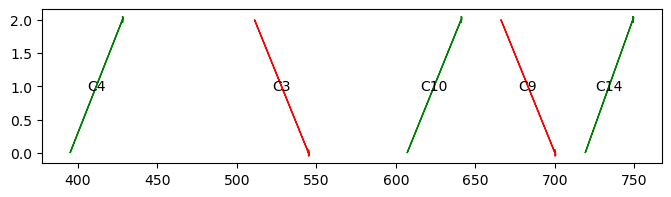

Train 5:
执行线路C7（down j=4）,离开A时间:10:11 到达B时间10:52 
执行线路C15（down j=8）,离开A时间:14:49 到达B时间15:23 
执行线路C21（down j=11）,离开A时间:18:37 到达B时间19:10 
执行线路C2（up i=1）, 离开B时间:6:17 到达A时间6:51 
执行线路C16（up i=8）, 离开B时间:12:59 到达A时间13:33 
执行线路C22（up i=11）, 离开B时间:16:12 到达A时间16:46 


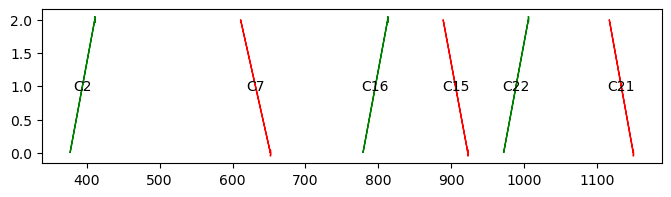

Train 6:
执行线路C11（down j=6）,离开A时间:12:10 到达B时间12:44 
执行线路C19（down j=10）,离开A时间:17:20 到达B时间17:54 
执行线路C23（down j=12）,离开A时间:20:55 到达B时间21:28 
执行线路C8（up i=4）, 离开B时间:9:15 到达A时间9:56 
执行线路C20（up i=10）, 离开B时间:15:39 到达A时间16:13 
执行线路C24（up i=12）, 离开B时间:18:11 到达A时间18:48 


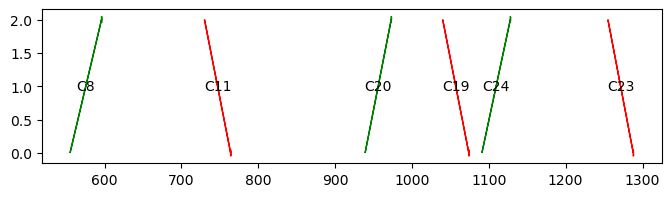

Train 7:


<Figure size 800x200 with 0 Axes>

Train 8:
执行线路C1（down j=1）,离开A时间:6:13 到达B时间6:57 
执行线路C5（down j=3）,离开A时间:9:29 到达B时间10:03 
执行线路C13（down j=7）,离开A时间:12:49 到达B时间13:23 
执行线路C17（down j=9）,离开A时间:15:06 到达B时间15:36 
执行线路C6（up i=3）, 离开B时间:7:24 到达A时间7:58 
执行线路C12（up i=6）, 离开B时间:11:15 到达A时间11:49 
执行线路C18（up i=9）, 离开B时间:13:55 到达A时间14:29 


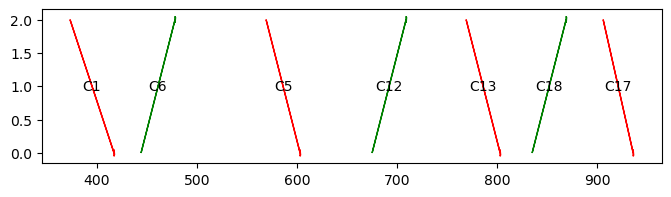

Train 9:


<Figure size 800x200 with 0 Axes>

In [24]:
# 满足车辆数量<=4的情况下，总空闲最短时间（求解时间约15分钟）
print(f"Best Motive number:{value(TotalMotive)}")
print(f"Shorest wait time:{value(TotalWait)}")
import matplotlib.pyplot as plt
if LpStatus[prob.status] == "Optimal":
    for k in range(1,MOTIVE_NUM+1):
        print(f"Train {k}:")
        plt.figure(figsize = (8,2))
        for i in range(0,M+1):
            for j in range(1, N+1):
                if value(x_up[i,j,k]) == 1:
                    # 绘制带箭头的线段
                    dx = value(tj_e[j]) - value(tj_s[j])
                    dy = -2
                    plt.arrow(value(tj_s[j]), 2, dx, dy, head_width=0.1, head_length=0.5, fc='red', ec='red')
                    # 添加文字标签
                    plt.text(value(tj_s[j])+dx/2, 1, f"{downtrain.iloc[j-1]['车次']}", ha='center', va='center')
                    print(f"执行线路{downtrain.iloc[j-1]['车次']}（down j={j}）,离开A时间:{min2time(value(tj_s[j]))} 到达B时间{min2time(value(tj_e[j]))} ")
        for j in range(0,N+1):
            for i in range(1, M+1):
                if value(x_down[j,i,k]) == 1:
                    # 绘制带箭头的线段
                    dx = value(ti_e[i]) - value(ti_s[i])
                    dy = 2
                    plt.arrow(value(ti_s[i]), 0, dx, dy, head_width=0.1, head_length=0.5, fc='green', ec='green')
                    plt.text(value(ti_s[i])+dx/2, 1, f"{uptrain.iloc[i-1]['车次']}", ha='center', va='center')
                    print(f"执行线路{uptrain.iloc[i-1]['车次']}（up i={i}）, 离开B时间:{min2time(value(ti_s[i]))} 到达A时间{min2time(value(ti_e[i]))} ")
        plt.show()
else:
    print("No solution")

可以看到，最短怠速时间 = 1591.0（分钟）